# Projeto Final 2019

**Aluno:** Franklin Alves de Oliveira

-----

Neste projeto cada aluno deve eleger um corpus de documentos de tamanho medio (pelo menos milhares de documentos). Todas as tarefas a seguir serao realizadas sobre este corpus.

-----

Então, vamos começar importando o *corpus* de *reviews* de produtos eletrônicos do site [Amazon.com](https://www.amazon.com). Esse corpus, e outros semelhantes, podem ser encontrados nesse [link](http://jmcauley.ucsd.edu/data/amazon/). 

Para esse projeto, vamos utilizar uma amostra de aproximadamente 300 mil reviews (selecionados aleatoriamente) de um total de 1.689.188 no *corpus* completo.

<br>

Antes de começarmos, vamos fazer os ***imports*** de alguns pacotes...

In [1]:
# imports
import os
import re
import nltk
import math
import string
import shutil
import gensim
import whoosh
import enchant
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# imports de funcionalidades diversas
from tqdm import tqdm
from string import punctuation
from IPython.display import display, Markdown, Latex
from collections import defaultdict,Counter,OrderedDict
from sklearn.feature_extraction.text import TfidfVectorizer

# imports do nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer as WPT
from nltk.stem.snowball import SnowballStemmer

**Configurações iniciais:**

In [2]:
nltk.download('stopwords')
swu = stopwords.words('english') + list(string.punctuation)
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/franklin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Importando o _corpus_**:

In [3]:
# OBS: estou mantendo o índice do corpus original (completo)
df = pd.read_csv('../Amazon_electronics_reviews_sample.csv', encoding='utf-8-sig', index_col=0)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
1,AMO214LNFCEI4,0528881469,Amazon Customer,"[12, 15]","I'm a professional OTR truck driver, and I bou...",1.0,Very Disappointed,1290643200,"11 25, 2010"
5,A2JXAZZI9PHK9Z,0594451647,"Billy G. Noland ""Bill Noland""","[3, 3]",I am using this with a Nook HD+. It works as d...,5.0,HDMI Nook adapter cable,1388707200,"01 3, 2014"
9,A3BY5KCNQZXV5U,0594451647,Matenai,"[3, 3]",This product really works great but I found th...,5.0,This works great but read the details...,1390176000,"01 20, 2014"
15,AT09WGFUM934H,0594481813,John,"[0, 0]",It does 2A and charges a DEAD Nook in a few ho...,3.0,This is the oem charger you get with the nook hd+,1377907200,"08 31, 2013"
20,A1EDI0X3GI1SK7,0972683275,AGW,"[0, 1]","Great deal, easy to mount and it appears to be...",5.0,32 In TV Mount,1323993600,"12 16, 2011"


In [4]:
corpus = df[['reviewerID', 'asin', 'reviewText']].copy()
print('Nº de observações no corpus:', corpus.shape[0])

Nº de observações no corpus: 299789


<br>

## Indexação
1. Utilizando o Whoosh indexar o seu corpus e implementar uma funçao que apresentes para os top 10 documentos da resposta a uma consulta, trechos dos documentos contendo os termos da consulta.
1. Contruir uma funçao de busca que aceite consultas frasais e facetaçao dos resultados.

In [24]:
# imports do whoosh
import whoosh.index as index
from whoosh import qparser
from whoosh import sorting
from whoosh.fields import *
from whoosh.qparser import QueryParser
from whoosh.index import create_in, open_dir

**definindo funções para criar o índice e fazer a busca**

In [23]:
def create_whoosh_id(corpus, schema):
    '''
    cria um índice no whoosh. 
    
    Argumentos:
        - corpus (list or array): lista de textos
        - schema (Schema whoosh obj): schema para criação do índice 
    '''
    # schema para criação do índice
    schema = Schema(cont=TEXT(phrase=True, stored=True))
    
    # criando índice no whoosh (armazenado na pasta ./indexdir)
    if index.exists_in('indexdir'):
        shutil.rmtree('./indexdir', ignore_errors=True) # limpa/remove o índice atual
        ix = create_in("indexdir", schema)              # cria novo índice
        writer = ix.writer()
        for text in corpus:
            writer.add_document(cont=text)
        writer.commit()
    else:
        os.mkdir('indexdir')
        ix = create_in("indexdir", schema)
        writer = ix.writer()
        for txt in corpus:
            writer.add_document(cont=txt)
        writer.commit()
    return ix

In [30]:
def search(query, corpus, schema = None, n_results=5, index= None, return_pos= False):
    '''
    Faz uma busca por palavras ou frases no corpus.
    
    Argumentos:
        - query (string): frase a ser buscada
        - corpus (array or list): lista de textos
        - n_results (int): números de resultados para exibição.
        - index (whoosh index obj.): indexador do whoosh 
        - return_pos (bool): se True, retorna uma lista com as posições onde a busca foi encontrada.
    '''
    # Se não for passado um índice, a função criará um com um schema padrão
    if index == None:
        schema = Schema(cont=TEXT(phrase=True, stored=True))
        index = create_whoosh_id(corpus, schema)
    
    # listas para armazenar os resultados
    pos=[]
    trechos=[]
    
    # faz a consulta
    query = QueryParser("cont", schema=idx.schema,group=qparser.OrGroup).parse(query)
    facets = sorting.Facets()
    facets.add_field("cont", allow_overlap=True)
    ans = index.searcher().search(query,limit= n_results, groupedby= facets)
    for A in ans:
        pos.append(corpus[corpus.isin([A.values()[0]])].index[0])
        trechos.append(re.split("\.\.\.", A.highlights("cont")))
        if len(pos) >= n_results:
            break
    
    # exibindo os resultados  
    n_results = min(len(trechos), n_results)
    print(f'Foram encontrados \033[1m{len(trechos)}\033[0m resultados (Exibindo os \033[1m{n_results}\033[0m primeiros).')
    print(' ')
    for i in range(n_results):
        print(f'\033[94m\033[4mResultado {i+1} ' + f'(índice {pos[i]} do df):\033[0m')
        for j in range(min(5,len(trechos[i]))): # mostra, no máximo, 5 linhas/matches para cada resultado
            display(Markdown(f'- {j+1}:  ...  '+trechos[i][j]+'  ...'))
        print('')
        
    if return_pos:
        return pos

In [26]:
# criando um índice com o whoosh
# schema = Schema(cont=TEXT(phrase=True, stored=True))
# idx = create_whoosh_id(corpus['reviewText'], schema)  

# se o índice já foi criado, executar a linha abaixo
idx = index.open_dir("indexdir")

In [31]:
# exibe resultados do mais para o menos similar
search('really works', corpus['reviewText'], index=idx, n_results=10)

Foram encontrados 10 resultados (Exibindo os 10 primeiros).
 
Resultado 1 (índice 1390828 do df):


- 1:  ...  <b class="match term0">Works</b> well and it appears <b class="match term1">really</b> sturdy.  quality of  ...

- 2:  ...  the cable is <b class="match term1">really</b> good.  <b class="match term0">Works</b> well with the Samsung  ...


Resultado 2 (índice 1608496 do df):


- 1:  ...  so this graphic card <b class="match term2">works</b> perfect for me. Is <b class="match term1">really</b> cheap and <b class="match term2">works</b> <b class="match term1">really</b> well in my new system  ...

- 2:  ...  Blu-ray movies play <b class="match term1">really</b> well with this card  ...


Resultado 3 (índice 1168258 do df):


- 1:  ...  This thing <b class="match term2">works</b> great, no wonder it  ...

- 2:  ...  that comes with it <b class="match term2">works</b> <b class="match term1">really</b> good, and looks so  ...

- 3:  ...  that you don't <b class="match term1">really</b> see it until <b class="match term1">really</b> <b class="match term1">really</b> close up. Just buy  ...


Resultado 4 (índice 1163589 do df):


- 1:  ...  This processor <b class="match term2">works</b> <b class="match term1">really</b> great for a project  ...

- 2:  ...  on a low budget and <b class="match term2">works</b> <b class="match term1">really</b> good  ...


Resultado 5 (índice 850504 do df):


- 1:  ...  <b class="match term0">Works</b> <b class="match term1">really</b> well to spead the  ...

- 2:  ...  flash a bit more and <b class="match term2">works</b> <b class="match term1">really</b> well, is easy to put  ...


Resultado 6 (índice 681402 do df):


- 1:  ...  <b class="match term0">Works</b> only for still pics, video does not start or  ...

- 2:  ...  the half touch focus <b class="match term1">really</b> <b class="match term2">works</b>, so self portraits  ...

- 3:  ...  <b class="match term1">really</b> <b class="match term1">really</b> easy. max range i have  ...


Resultado 7 (índice 1414510 do df):


- 1:  ...  screen protector <b class="match term2">works</b> <b class="match term1">really</b> well ive been told  ...

- 2:  ...  that they are not <b class="match term1">really</b> needed with the gorilla  ...

- 3:  ...  be safe than sorry.  <b class="match term2">works</b> great  ...


Resultado 8 (índice 78097 do df):


- 1:  ...  It <b class="match term2">works</b> fine. Not the best! If  ...

- 2:  ...  your lens, yes, it <b class="match term2">works</b> great for the there  ...

- 3:  ...  If you looking for a <b class="match term1">really</b> <b class="match term1">really</b> nice polarized lens  ...


Resultado 9 (índice 1023369 do df):


- 1:  ...  Item <b class="match term2">works</b> good and for it's intended  ...

- 2:  ...  for item. Nothing to <b class="match term1">really</b> complain about. <b class="match term0">Works</b> <b class="match term1">really</b> good. So much easier  ...


Resultado 10 (índice 1543699 do df):


- 1:  ...  <b class="match term0">Works</b> perfectly and is <b class="match term1">really</b>, <b class="match term1">really</b>, <b class="match term1">really</b> fast. If this is a typical  ...

<br>

## Modelagem de Assuntos
1. Usando a biblioteca Gensim, treine um modelo LSI e LDA para o seu corpus propondo uma metodologia para otimizaçao do número de assuntos
2. Construa uma matriz de similaridade entre os documentos do corpus a partir dos pesos 

<font color='blue'>**Links interessantes:**</font>

> - **LSI (Latent Semantic Indexing) or LSA (Latent semantic analysis):** [Wikipedia](https://en.wikipedia.org/wiki/Latent_semantic_analysis)
<br>
>
> - **LDA (Latent Dirichlet Allocation):** [Wikipedia](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)

<br>

## item 1

In [5]:
import pickle

# imports adicionais do gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, wrappers

### Pré-processamento do texto

<font color='red'>**Obs:** verifiquei que os resultados ficaram melhores sem remover stopwords e sem "stemizar" o texto - ao fazer isso, apareciam algumas inconsistências como letras soltas e 'sony' se tornava 'son', que têm significados bem distintos </font>

In [6]:
def tokenize_and_remove_sw(text,sw,remove_sw=True, stemize=True):
    '''
    Tokeniza o texto e remove stopwords.
    
    Argumentos:
        - text (string): texto.
        - sw (list): lista de stopwords.
        - remove_sw (bool): se True, remove stopwords.
        - stemize (bool): se True, aplica stemmer ao texto.
    '''
    if remove_sw and stemize:
        clean_text = [stemmer.stem(token.strip(punctuation).lower()) for token in 
                                                   WPT().tokenize(text) if token not in sw]
    elif remove_sw:
        clean_text = [token.strip(punctuation).lower() for token in 
                                                   WPT().tokenize(text) if token not in sw]
    elif stemize:
        clean_text = [stemmer.stem(token.strip(punctuation).lower()) for token in 
                                                   WPT().tokenize(text)]
    else:
        clean_text = [token.strip(punctuation).lower() for token in 
                                                   WPT().tokenize(text)]
    return clean_text

In [7]:
def train_models(texts, min_count=1, model=None, n_topics=8):
    counter = Counter([])
    for text in texts:
        counter.update(text)
    # retorna mensagem de erro se nenhum modelo é especificado
    if model == None:
        return 'Error: Please pass value to model argument from ["tf-idf", "lsi", "lda"]'
    
    # lista de modelos a serem estimados
    model = list(model)
    
    # mantém tokens que aparecem ao menos duas vezes
    list_of_texts = [[token for token in text if counter[token] > min_count] 
                                                 for text in texts]  
    # criando dicionário:
    dic = corpora.Dictionary(list_of_texts)
    dic.save('vocab.dict')
    
    # criando listas de frequências:
    frequency_lists = [dic.doc2bow(token) for token in list_of_texts]
    corpora.MmCorpus.serialize('frequency_list.mm', frequency_lists)
    
    res = []  # lista para armazenar os resultados
    #tf-idf:
    if sum(['idf' in s for s in model]) > 0:
        tfidf = models.TfidfModel(frequency_lists)
        tfidf.save('tfidf_model.mm')
        corpus_tfidf = tfidf[frequency_lists]
        res.extend([tfidf, corpus_tfidf])
    
    #LSI:
    if sum(['lsi' in s for s in model]) > 0:
        # checa se o tf-idf foi treinado
        if len(res) == 0:
            return 'Oops. To compute LSI models is necessary to include TF-IDF.'
        mod_lsi = models.LsiModel(corpus_tfidf, id2word= dic, num_topics=n_topics)
        mod_lsi.save('LSI_model.mm')
        corpus_lsi = mod_lsi[corpus_tfidf] # alimento com 
        res.extend([mod_lsi, corpus_lsi])
        
    #LDA:
    if sum(['lda' in s for s in model]) > 0:
        mod_lda = models.LdaModel(frequency_lists, id2word= dic, num_topics=n_topics)
        mod_lda.save('LDA_model.mm')
        corpus_lda = mod_lda[frequency_lists] 
        res.extend([mod_lda, corpus_lda])

    return tuple(res)



def compute_lda_metrics(lda_model, min_count= 1,texts=None):  
    counter = Counter([])
    for text in texts:
        counter.update(text)

    # mantém apenas tokens que aparecem ao menos duas vezes
    list_of_texts = [[token for token in text if counter[token] > min_count] 
                                                 for text in texts]
    # criando dicionário:
    dic = corpora.Dictionary(list_of_texts)
    
    # criando listas de frequências:
    frequency_lists = [dic.doc2bow(token) for token in list_of_texts]
    
    # Compute Perplexity
    perplexity = lda_model.log_perplexity(frequency_lists)
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts= list_of_texts, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    
    return (perplexity, coherence_lda)

### stemizando e removendo stopwords

<font color='red'>**OBS:** optei por não stem-izar o texto para não perder muito em precisão</font>

In [8]:
n = corpus.shape[0]  # número de obs
corpus['tokenized_reviews'] = corpus['reviewText'].iloc[:n].apply(lambda x:
                            tokenize_and_remove_sw(x, swu, stemize=False, remove_sw=True))

### Selecionando o número de tópicos

Agora, vamos treinar o modelo **LDA** para diferentes números de tópicos e selecionar a quantidade que maximiza o score de coerência.

In [9]:
perplexity = []
coherence = []
num_topics = []

n = 200000  # número de observações p/ analisar qtde ótima de tópicos (tamanho da subamostra)
for k in tqdm(range(1,41)):
    # treinando os modelos
    lda_model, lda = train_models(corpus['tokenized_reviews'].iloc[:n], 
                                                        model=['lda'], n_topics=k)
    
    metrics = compute_lda_metrics(lda_model, texts=corpus['tokenized_reviews'].iloc[:n])
    perplexity.append(metrics[0])
    coherence.append(metrics[1])
    num_topics.append(k)

 76%|███████▌  | 38/50 [7:23:13<3:17:05, 985.47s/it]

KeyboardInterrupt: 

<br>

Não rodar a célula abaixo

In [12]:
perplexity = []
coherence = []
num_topics = []

n = 200000  # número de observações p/ analisar qtde ótima de tópicos (tamanho da subamostra)
for k in tqdm(range(1,21)):
    # treinando os modelos
    lda_model, lda = train_models(corpus['tokenized_reviews'].iloc[:n], 
                                                        model=['lda'], n_topics=k)
    
    metrics = compute_lda_metrics(lda_model, texts=corpus['tokenized_reviews'].iloc[:n])
    perplexity.append(metrics[0])
    coherence.append(metrics[1])
    num_topics.append(k)

100%|██████████| 20/20 [3:25:38<00:00, 616.94s/it]  


In [14]:
# salvando objetos em um pickle
# with open('./coherence_lda.pickle', 'wb') as f:
#     pickle.dump(coherence, f)
# with open('./ṕerplexity_lda.pickle', 'wb') as f:
#     pickle.dump(perplexity, f)

# lendo arquivos salvos em pickle
# with open('./coherence.pickle','rb') as f:
#     coherence = pickle.load(f)

# with open('./ṕerplexity.pickle','rb') as f:
#     perplexity = pickle.load(f)

# num_topics = list(range(1,21))

<br>

#### Gráfico: perplexidade e escore de coerência

Modelo LDA com 200 mil reviews

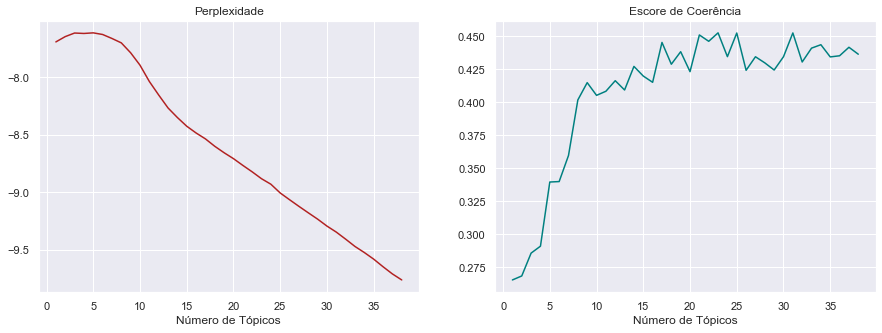

In [10]:
sns.set()
fig, ax = plt.subplots(ncols=2, figsize=(15,5));

ax[0].plot(num_topics, perplexity, color='firebrick');
ax[1].plot(num_topics, coherence, color='teal');

ax[0].set_xlabel('Número de Tópicos');
ax[1].set_xlabel('Número de Tópicos');

ax[0].set_title('Perplexidade');
ax[1].set_title('Escore de Coerência');

LDA anterior (com tf-idf)

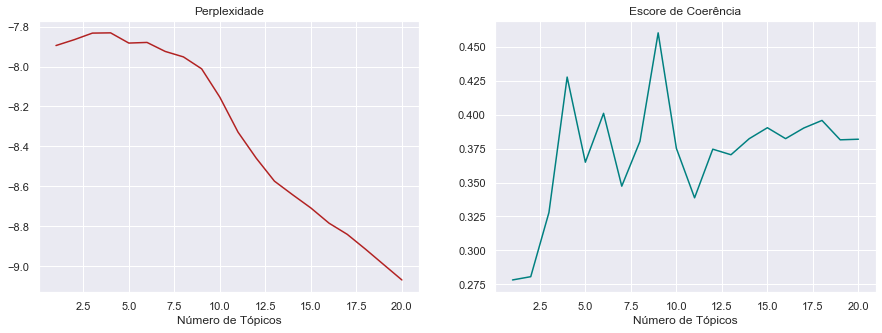

In [13]:
sns.set()
fig, ax = plt.subplots(ncols=2, figsize=(15,5));

ax[0].plot(num_topics, perplexity, color='firebrick');
ax[1].plot(num_topics, coherence, color='teal');

ax[0].set_xlabel('Número de Tópicos');
ax[1].set_xlabel('Número de Tópicos');

ax[0].set_title('Perplexidade');
ax[1].set_title('Escore de Coerência');

In [12]:
# encontrando o número de tópicos que maximiza o escore de coerência
sorted(tuple(zip(num_topics,coherence)), key=lambda tup:tup[1], reverse=True)[:10]

[(23, 0.4527062104047758),
 (31, 0.4526373697864123),
 (25, 0.45258632924255204),
 (21, 0.45111412589600974),
 (22, 0.44629280228803486),
 (17, 0.4454373980236002),
 (34, 0.4437034525007237),
 (37, 0.44176435723933843),
 (33, 0.44110337094257235),
 (19, 0.43839501761541655)]

Analisando os gráficos acima, temos que a quantidade de tópicos que maximiza o escore de coerência e minimiza a métrica de perplexidade é $9$. Agora, vamos computar os modelos para essa quantidade de tópicos.

In [15]:
# treinando os três modelos
tfidf_model, tfidf, lsi_model, lsi, lda_model, lda = train_models(corpus['tokenized_reviews'].iloc[:n], 
                                                            model=['tf-idf', 'lsi', 'lda'], n_topics=23)

<font color='red'>**OBS:** Se os modelos já foram treinados, basta executar as duas próximas células para carregá-los. </font>

In [79]:
# dicionário de palavras do corpus
for i in range(200):
    print(dic[i], end='; ')

; 000; 13; 15; 23; 30; 5; 53; 6; 700; 71; 75; 80; across; address; advised; after; almost; another; area; attempt; available; az; back; blocks; bought; box; card; cards; cell; chain; chance; charging; cheap; check; checks; cincinnati; city; completely; connect; could; country; couple; cross; decided; detected; devices; drive; driver; easier; easy; especially; every; exciting; figure; finally; first; freeway; friend; get; getting; give; google; got; gotten; gps; happened; hasn; head; height; hello; highways; home; hop; hoping; however; i; if; indeed; install; intersection; laptop; length; life; listening; live; lost; make; mcnally; might; miles; minute; minutes; money; months; multiple; my; need; needed; next; no; north; now; oh; otr; parked; passed; patch; phoenix; phone; pick; pickup; po; posted; preferred; print; printer; problem; professional; program; programmed; purchased; ran; rand; refused; residential; returned; rig; route; routed; said; sd; send; sent; set; several; short; sid

In [59]:
# ### carregando corpus no formato de listas de frequências
dic = corpora.Dictionary.load('vocab.dict')
# frequency_lists = corpora.MmCorpus('frequency_list.mm')

# ### carregando os três modelos
# # TF-IDF
# tfidf_model = models.tfidfmodel.TfidfModel.load('tfidf_model.mm')
# tfidf = tfidf_model[frequency_lists]

# # LSI
# lsi_model = models.LsiModel.load('LSI_model.mm')
# lsi = lsi_model[tfidf]

# # LDA
# lda_model = models.LdaModel.load('LDA_model.mm')
# lda = lda_model[tfidf]

#### TF-IDF

Abaixo, temos um exemplo de tf-idf para o primeiro *review* do corpus. (id_termo, frequência)

In [54]:
# palavra
corpus['tokenized_reviews'].iloc[0][156]

'turn'

Importância das palavras pelo TF-IDF

In [53]:
# exemplo: tf-idf para o primeiro texto
sorted(tfidf[0], key=lambda tupla: tupla[1],reverse=True)[:10]

[(157, 0.49261299650083645),
 (162, 0.35297960471254014),
 (9, 0.2577533103927648),
 (111, 0.23227069734536668),
 (128, 0.17972528091352707),
 (36, 0.16374069637406202),
 (10, 0.14414160985069352),
 (11, 0.13630603804715644),
 (57, 0.12573218793044033),
 (148, 0.11277674263477334)]

#### LSI

In [55]:
sorted(lsi[0], key=lambda tupla:tupla[1], reverse=True)[:10]

[(0, 0.1280967117434524),
 (4, 0.0499527107839919),
 (5, 0.02607153340621488),
 (3, 0.01490118326622253),
 (9, 0.011347499800449095),
 (14, 0.00792282145769382),
 (10, 0.007109918698776047),
 (18, 0.007084522304300146),
 (1, 0.006709047811765355),
 (7, 0.005252366558068911)]

In [16]:
lsi_model.print_topics(num_topics=5, num_words=6)

[(0,
  '0.175*"" + 0.172*"i" + 0.131*"the" + 0.128*"great" + 0.123*"it" + 0.121*"camera"'),
 (1,
  '-0.512*"camera" + -0.426*"lens" + 0.244*"cable" + 0.168*"tv" + -0.158*"canon" + 0.157*"sound"'),
 (2,
  '0.367*"sound" + -0.302*"drive" + 0.237*"headphones" + -0.231*"mouse" + 0.205*"speakers" + -0.191*"usb"'),
 (3,
  '-0.527*"cable" + 0.347*"mouse" + -0.226*"tv" + -0.225*"hdmi" + -0.196*"cables" + 0.192*"keyboard"'),
 (4,
  '-0.471*"mouse" + 0.389*"drive" + -0.232*"cable" + -0.205*"keyboard" + 0.185*"card" + -0.182*"works"')]

O tópico 1 parece estar associado à equipamentos de fotografia, pois aparecem as palavras **camera**, **lens**, **cable**, **canon**.

Já os tópico 2, parece estar associado à periféricos de informática, pois aparecem as palavras **headphones**, **sound**, **drive**, **speakers** e **usb**.

#### LDA

In [17]:
lda[0]

[(0, 0.06560628),
 (3, 0.48942292),
 (5, 0.013592613),
 (9, 0.039661914),
 (10, 0.11001743),
 (13, 0.02577081),
 (14, 0.082419224),
 (17, 0.035566118),
 (20, 0.084680855),
 (22, 0.038219564)]

In [57]:
lda_model.print_topics(num_topics=8, num_words=8)

[(11,
  '0.126*"" + 0.056*"34" + 0.018*"mount" + 0.015*"the" + 0.013*"easy" + 0.012*"install" + 0.011*"sata" + 0.011*"it"'),
 (16,
  '0.114*"camera" + 0.043*"i" + 0.023*"video" + 0.020*"pictures" + 0.018*"cameras" + 0.014*"the" + 0.013*"photos" + 0.012*"canon"'),
 (19,
  '0.042*"i" + 0.036*"sound" + 0.031*"speakers" + 0.031*"player" + 0.019*"speaker" + 0.018*"system" + 0.015*"" + 0.014*"music"'),
 (3,
  '0.126*"i" + 0.020*"" + 0.019*"one" + 0.008*"would" + 0.008*"get" + 0.008*"amazon" + 0.008*"time" + 0.008*"got"'),
 (18,
  '0.081*"i" + 0.045*"great" + 0.038*"price" + 0.032*"good" + 0.025*"works" + 0.022*"product" + 0.022*"quality" + 0.019*"well"'),
 (13,
  '0.084*"battery" + 0.037*"charge" + 0.034*"batteries" + 0.030*"charger" + 0.025*"kindle" + 0.019*"life" + 0.016*"i" + 0.016*"the"'),
 (20,
  '0.028*"fan" + 0.017*"ray" + 0.016*"blu" + 0.013*"front" + 0.011*"i" + 0.011*"cpu" + 0.010*"the" + 0.010*"air"'),
 (5,
  '0.051*"sound" + 0.031*"i" + 0.028*"headphones" + 0.020*"ear" + 0.020*"t

O tópico 19 parece estar associado a aparelhos de som, pois aparecem as palavras **sound**, **speakers**, **system**, **music**.

O tópico 3 parece estar associado a reviews positivos, pois aparecem as palavras **get**, **time**, **amazon**.

## item 2

### Construindo matriz de similaridades.

In [20]:
def create_similarity_matrix(model, n=10):
    '''
    Cria matriz de similaridade.
    
    Argumentos:
        - model (gensim model obj.): um dos três modelos (tf-idf, LSI ou LDA)
        - n (int): # de documentos para calcular as similaridades (dimensão da matriz)
    '''
    head = corpus.iloc[:n,].index  # estou usando índice do dataframe para identificação
    source = [elem[:n] for elem in list(similarities.MatrixSimilarity(model))][:n]

    similarity_matrix = pd.DataFrame(source, index= head.values, columns= head)
    return similarity_matrix

In [58]:
# não consegui executar antes da apresentação (memória RAM cheia com os objetos)
create_similarity_matrix(tfidf, 10)

MemoryError: Unable to allocate array with shape (200000, 62382) and data type float32

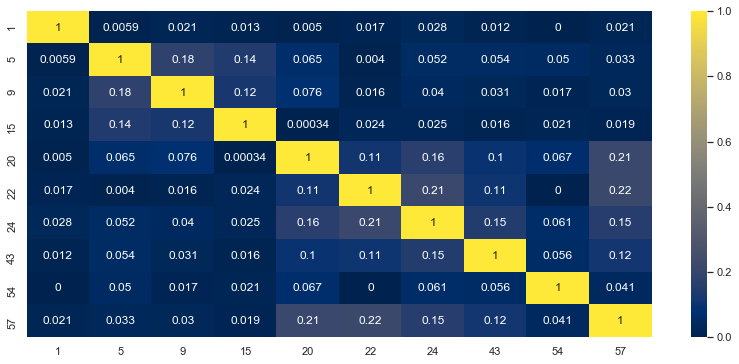

In [51]:
plt.figure(figsize=(14,6))
sns.heatmap(create_similarity_matrix(tfidf, 10), cmap='cividis', annot=True)

# corrigindo "bug" do seaborn (cortando pela metade a primeira e última linha)
b, t = plt.ylim() # limites de y
b += 0.5 # lim. inferior + 0.5
t -= 0.5 # lim. superior - 0.5
plt.ylim(b, t) # atualiza ylim
plt.show()

<br>

## Word2vec
1. Ainda usando a biblioteca Gensim, Construa uma representaçao vetorial semantica(word2vec) do seu corpus de escolha. Podem seguir este [tutorial](https://rare-technologies.com/word2vec-tutorial/)
2. Construa uma representaçao simila usando [FastText](https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText). Veja este [Tutorial](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/FastText_Tutorial.ipynb)

### **Configurações iniciais**

In [ ]:
### Executar a linha abaixo se quiser visualizar um logging da execução do modelo
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

### **Pré-processando o texto (tokenizando e removendo stopwords)**

<font color='red'>**Obs:** verifiquei que os resultados ficaram melhores sem stem-izar o texto - ao fazer isso, apareciam algumas inconsistências como letras e números soltos. </font>

In [57]:
# n = corpus.shape[0]  # número de observações
# corpus['tokenized_rewiews'] = corpus['reviewText'].iloc[:n].apply(lambda x:
#                             tokenize_and_remove_sw(x, swu, stemize=True, remove_sw=True))

### Treinando modelo Word2Vec

In [9]:
def train_W2V(list_tokenized_texts, min_count=1, workers=2, n_epochs= 5):
    '''
    Treina o modelo Word2Vec e retorna o objeto gensim.models.Word2Vec. 
    
    Cria os seguintes arquivos na pasta local:
        - vocab_W2V.dict: vocabulário
        - corpusWikiW2V.mm: lista de frequências 
        - w2v_mode.sav: modelo Word2Vec (gensim)
        
    Argumentos:
        - list_tokenized_texts (list): lista de textos tokenizados
        - min_count (int): frequência mínima para contar tokens
        - workers (int): número de threads para treinar o modelo W2V.
        - n_epochs (int): número de épocas para treinar o modelo.
    '''
    counter = Counter([])
    for text in list_tokenized_texts:
        counter.update(text)
        
    # mantém apenas tokens que aparecem ao menos duas vezes
    list_of_texts = [[token for token in text if counter[token] > min_count] 
                                                 for text in list_tokenized_texts]
    
    # criando dicionário:
    dic = corpora.Dictionary(list_of_texts)
    dic.save('vocab_W2V.dict')
    
    # criando listas de frequências:
    frequency_lists = [dic.doc2bow(token) for token in list_of_texts]
    corpora.MmCorpus.serialize('frequency_list_W2V.mm', frequency_lists)
    
    # treinando W2V:
    mod_w2v = models.Word2Vec(list_of_texts, min_count=min_count, workers=workers, iter= n_epochs)
    mod_w2v.save('w2v_model.sav')
    
    return mod_w2v

In [33]:
n = 200000  # número de observações
# w2v = train_W2V(list(corpus['tokenized_reviews'].iloc[:n]), n_epochs=20, workers=8)
w2v = gensim.models.Word2Vec.load('w2v_model.sav')
print(w2v)

Word2Vec(vocab=62382, size=100, alpha=0.025)


### Analisando elementos semelhantes

In [34]:
w2v.wv.most_similar(positive='sony')  

[('panasonic', 0.7396211624145508),
 ('mysony', 0.706706702709198),
 ('thesony', 0.6759231090545654),
 ('jvc', 0.6637254953384399),
 ('slt', 0.6583683490753174),
 ('philips', 0.646976113319397),
 ('dcr', 0.6364985108375549),
 ('ir100a', 0.6138120889663696),
 ('a77', 0.6124635934829712),
 ('xbr', 0.5994816422462463)]

In [37]:
w2v.wv.most_similar(positive='son')  

[('daughter', 0.9273725152015686),
 ('wife', 0.871778130531311),
 ('sister', 0.8597370386123657),
 ('husband', 0.8572892546653748),
 ('dad', 0.84247887134552),
 ('girlfriend', 0.8374909162521362),
 ('fiance', 0.8282933235168457),
 ('boyfriend', 0.8210633993148804),
 ('mom', 0.8206857442855835),
 ('grandson', 0.8182472586631775)]

In [36]:
w2v.wv.most_similar(positive='camera')  

[('dslr', 0.7286293506622314),
 ('cameras', 0.722560465335846),
 ('camcorder', 0.7022490501403809),
 ('slr', 0.6815106272697449),
 ('tripod', 0.6706822514533997),
 ('lens', 0.6514147520065308),
 ('evf', 0.6449236869812012),
 ('viewfinder', 0.6344794034957886),
 ('s95', 0.6193607449531555),
 ('d5100', 0.6190561056137085)]

In [31]:
w2v.wv.most_similar(positive='linux')  

[('ubuntu', 0.8291518688201904),
 ('win7', 0.802047610282898),
 ('vista', 0.7762501835823059),
 ('unix', 0.7684966325759888),
 ('64bit', 0.7578177452087402),
 ('osx', 0.7504874467849731),
 ('freebsd', 0.745354413986206),
 ('parallels', 0.7385203242301941),
 ('debian', 0.7353683114051819),
 ('distro', 0.7344064712524414)]

In [32]:
w2v.wv.n_similarity(['linux'], ['ubuntu'])

0.82915187

In [27]:
w2v.wv.closer_than('white', 'black')

['orange', 'gray', 'colored', 'grey', 'charcoal']

In [28]:
w2v.wv.closer_than('man', 'woman')

['lol', 'boys', 'lady', 'men', 'cave', 'dude']

-----

### Construindo uma representação similar com FastText

In [20]:
def train_FastText(list_tokenized_texts, min_count=1, workers=2, n_epochs= 5):
    '''
    Treina o modelo Word2Vec e retorna o objeto gensim.models.Word2Vec. 
    
    Cria os seguintes arquivos na pasta local:
        - vocab_W2V.dict: vocabulário
        - corpusWikiW2V.mm: lista de frequências 
        - w2v_mode.sav: modelo Word2Vec (gensim)
        
    Argumentos:
        - list_tokenized_texts (list): lista de textos tokenizados
        - min_count (int): frequência mínima para contar tokens
        - workers (int): número de threads para treinar o modelo W2V.
        - n_epochs (int): número de épocas para treinar o modelo.
    '''
    counter = Counter([])
    for text in list_tokenized_texts:
        counter.update(text)
        
    # mantém apenas tokens que aparecem ao menos duas vezes
    list_of_texts = [[token for token in text if counter[token] > min_count] 
                                                 for text in list_tokenized_texts]
    
    # criando dicionário:
    dic = corpora.Dictionary(list_of_texts)
    dic.save('vocab_W2V.dict')  # o vocabulário é idêntico ao criado para o W2V
    
    # criando listas de frequências:
    frequency_lists = [dic.doc2bow(token) for token in list_of_texts]
    corpora.MmCorpus.serialize('frequency_list.mm', frequency_lists)  # a lista de frequências tb é =
    
    # treinando W2V:
    mod_fast_txt = models.FastText(list_of_texts, min_count=min_count, workers=workers, iter= n_epochs)
    mod_fast_txt.save('fast_txt_model.sav')
    
    return mod_fast_txt

In [35]:
# n = 200000  # número de observações
# ft = train_FastText(list(corpus['tokenized_reviews'].iloc[:n]), n_epochs=20, workers=8)
ft = gensim.models.FastText.load('fast_txt_model.sav')
print(ft)

FastText(vocab=62382, size=100, alpha=0.025)


### Analisando elementos semelhantes

In [23]:
ft.wv.most_similar(positive='linux')  

[('puppylinux', 0.914942741394043),
 ('archlinux', 0.8761706352233887),
 ('pclinuxos', 0.8716403245925903),
 ('ubuntu', 0.8226170539855957),
 ('kubuntu', 0.8117600679397583),
 ('lynux', 0.808483898639679),
 ('xubuntu', 0.8062878251075745),
 ('n7', 0.787767767906189),
 ('win7', 0.7870563268661499),
 ('eeebuntu', 0.78593510389328)]

In [24]:
ft.wv.closer_than('white', 'black')

['colored',
 'grey',
 'whiter',
 'whitens',
 'colorpicker',
 'whitefor',
 'offwhite',
 'whiteish',
 'autowhite']

In [25]:
ft.wv.n_similarity(['linux'], ['ubuntu'])

0.8226171

**Fim!**